In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

# Load the Data

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Initialize the Model Architecture

In [3]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up the Model Backdoor

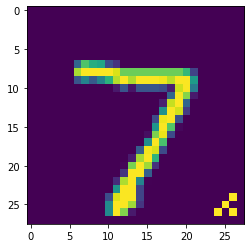

In [4]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

# Create the poison data
For this example, we will select 9 as the target class. Thus, the adversary's goal is to poison the model so adding a trigger will result in the trained model misclassifying the triggered input as a 9.

First, the adversary will create a proxy classifier (i.e., a classifier that is similar to the target classifier). As the clean label attack generates noise using PGD in order to encourage the trained classifier to rely on the trigger, it is important that the generated noise be transferable. Thus, adversarial training is used.

In [5]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
for i in range(len(poisoned)):
    if poisoned[i][0][0] != 0:
        plt.imshow(poisoned[i].squeeze())
        
        print(f"Index: {i} Label: {np.argmax(poisoned_labels[i])}")
        break

1039


# Initialize the classification models
We will initialize four models. The first is a single model architecture. The other three are DPA models with varying ensemble sizes to demonstrate the tradeoff between clean accuracy and poison accuracy

In [8]:
model = KerasClassifier(create_model())
dpa_model_10 = DeepPartitionEnsemble(model, ensemble_size=10)
dpa_model_20 = DeepPartitionEnsemble(model, ensemble_size=20)
dpa_model_30 = DeepPartitionEnsemble(model, ensemble_size=30)


Train the models on the poisoned data

In [9]:
model.fit(pdata, plabels, nb_epochs=10)
dpa_model_10.fit(pdata, plabels, nb_epochs=10)
dpa_model_20.fit(pdata, plabels, nb_epochs=10)
dpa_model_30.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 102us/sample - loss: 0.7220 - accuracy: 0.7746
Epoch 2/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.2600 - accuracy: 0.9204
Epoch 3/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.1606 - accuracy: 0.9509
Epoch 4/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.1183 - accuracy: 0.9648
Epoch 5/10
10000/10000 [==============================] - 1s 50us/sample - loss: 0.1025 - accuracy: 0.9689
Epoch 6/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0880 - accuracy: 0.9739
Epoch 7/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0622 - accuracy: 0.9813
Epoch 8/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0580 - accuracy: 0.9802
Epoch 9/10
10000/10000 [==============================] - 0s 50us/sample - loss: 0.0563 - accuracy: 0.9821
Epoch 10/10
1

1020/1020 [==============================] - 0s 51us/sample - loss: 0.2480 - accuracy: 0.9245
Epoch 9/10
1020/1020 [==============================] - 0s 51us/sample - loss: 0.1889 - accuracy: 0.9412
Epoch 10/10
1020/1020 [==============================] - 0s 53us/sample - loss: 0.1691 - accuracy: 0.9490
Train on 1056 samples
Epoch 1/10
1056/1056 [==============================] - 3s 3ms/sample - loss: 1.8210 - accuracy: 0.4460
Epoch 2/10
1056/1056 [==============================] - 0s 56us/sample - loss: 0.9038 - accuracy: 0.6932
Epoch 3/10
1056/1056 [==============================] - 0s 55us/sample - loss: 0.5929 - accuracy: 0.7879
Epoch 4/10
1056/1056 [==============================] - 0s 53us/sample - loss: 0.4960 - accuracy: 0.8419
Epoch 5/10
1056/1056 [==============================] - 0s 52us/sample - loss: 0.3916 - accuracy: 0.8826
Epoch 6/10
1056/1056 [==============================] - 0s 53us/sample - loss: 0.3037 - accuracy: 0.8939
Epoch 7/10
1056/1056 [======================

Epoch 3/10
512/512 [==============================] - 0s 52us/sample - loss: 1.1262 - accuracy: 0.6484
Epoch 4/10
512/512 [==============================] - 0s 52us/sample - loss: 0.8288 - accuracy: 0.7344
Epoch 5/10
512/512 [==============================] - 0s 59us/sample - loss: 0.6882 - accuracy: 0.7949
Epoch 6/10
512/512 [==============================] - 0s 53us/sample - loss: 0.5115 - accuracy: 0.8418
Epoch 7/10
512/512 [==============================] - 0s 53us/sample - loss: 0.5240 - accuracy: 0.8320
Epoch 8/10
512/512 [==============================] - 0s 53us/sample - loss: 0.4907 - accuracy: 0.8398
Epoch 9/10
512/512 [==============================] - 0s 53us/sample - loss: 0.3853 - accuracy: 0.8848
Epoch 10/10
512/512 [==============================] - 0s 52us/sample - loss: 0.3691 - accuracy: 0.8711
Train on 470 samples
Epoch 1/10
470/470 [==============================] - 1s 1ms/sample - loss: 2.1604 - accuracy: 0.2936
Epoch 2/10
470/470 [==============================] 

Train on 323 samples
Epoch 1/10
323/323 [==============================] - 8s 26ms/sample - loss: 2.2482 - accuracy: 0.2074
Epoch 2/10
323/323 [==============================] - 0s 119us/sample - loss: 1.8657 - accuracy: 0.4582
Epoch 3/10
323/323 [==============================] - 0s 61us/sample - loss: 1.3584 - accuracy: 0.6285
Epoch 4/10
323/323 [==============================] - 0s 63us/sample - loss: 1.0217 - accuracy: 0.6811
Epoch 5/10
323/323 [==============================] - 0s 60us/sample - loss: 0.7799 - accuracy: 0.7647
Epoch 6/10
323/323 [==============================] - 0s 63us/sample - loss: 0.5979 - accuracy: 0.8019
Epoch 7/10
323/323 [==============================] - 0s 72us/sample - loss: 0.5943 - accuracy: 0.7771
Epoch 8/10
323/323 [==============================] - 0s 61us/sample - loss: 0.4313 - accuracy: 0.8607
Epoch 9/10
323/323 [==============================] - 0s 61us/sample - loss: 0.3897 - accuracy: 0.8607
Epoch 10/10
323/323 [==============================

Epoch 6/10
334/334 [==============================] - 0s 60us/sample - loss: 0.7031 - accuracy: 0.7725
Epoch 7/10
334/334 [==============================] - 0s 60us/sample - loss: 0.6122 - accuracy: 0.7994
Epoch 8/10
334/334 [==============================] - 0s 59us/sample - loss: 0.4986 - accuracy: 0.8503
Epoch 9/10
334/334 [==============================] - 0s 61us/sample - loss: 0.4208 - accuracy: 0.8653
Epoch 10/10
334/334 [==============================] - 0s 61us/sample - loss: 0.3740 - accuracy: 0.8862
Train on 349 samples
Epoch 1/10
349/349 [==============================] - 1s 2ms/sample - loss: 2.2140 - accuracy: 0.2006
Epoch 2/10
349/349 [==============================] - 0s 59us/sample - loss: 1.7700 - accuracy: 0.5158
Epoch 3/10
349/349 [==============================] - 0s 58us/sample - loss: 1.2889 - accuracy: 0.6332
Epoch 4/10
349/349 [==============================] - 0s 58us/sample - loss: 0.8781 - accuracy: 0.7077
Epoch 5/10
349/349 [==============================] 

# Evaluate the performance of the trained models on unpoisoned data
The performance of the models appears normal. We see that for the DPA models, the performance drops slightly as the ensemble size increases


Clean test set accuracy (model): 98.03%


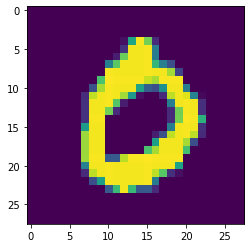

Prediction: 0


In [10]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (model): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model): 93.94%


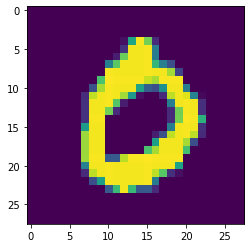

Prediction: 0


In [11]:
clean_preds = np.argmax(dpa_model_10.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model): 91.36%


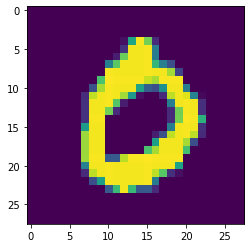

Prediction: 0


In [12]:
clean_preds = np.argmax(dpa_model_20.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model): 90.05%


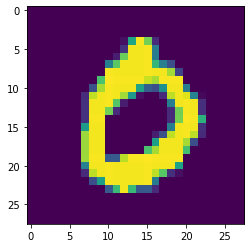

Prediction: 0


In [13]:
clean_preds = np.argmax(dpa_model_30.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

# Evaluate the performance of the trained models on poisoned data
When the trigger is added, we see a shift in performance. The single model performs the worst as no defense is in place to mitigate the effect of the poisoned. The DPA models show some robustnesss to the poison as they partition the training data, which spreads the effect of the poison between models in the ensemble.


Poison test set accuracy (model): 0.01%


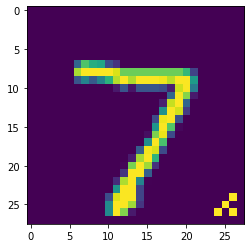

Prediction: 9


In [14]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model): 73.76%


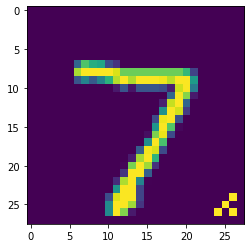

Prediction: 7


In [15]:
poison_preds = np.argmax(dpa_model_10.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model): 74.80%


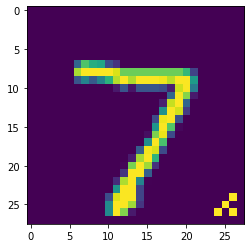

Prediction: 7


In [16]:
poison_preds = np.argmax(dpa_model_20.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model): 74.66%


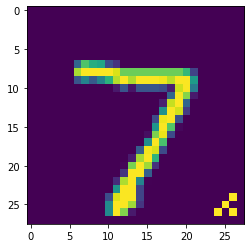

Prediction: 7


In [17]:
poison_preds = np.argmax(dpa_model_30.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))

In [33]:
pp = dpa_model_30.predict(px_test)


In [34]:
(np.sum(pp, axis=1) <= 30*np.ones((len(px_test),))).all()

True

In [30]:
pp[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.], dtype=float32)